# Análisis No Supervisado: PCA + K-Means
Este notebook implementa un pipeline para:
- Cargar datos de Home Credit (archivos Parquet).
- Generar variables agregadas.
- Preparar datos (manejo de nulos, estandarización).
- Aplicar PCA y K-Means.
- Visualizar clusters y analizar relación con TARGET.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# Definir ruta base (ajustar según ubicación real)
ruta_base = Path(r".\datos_examen")

# Cargar archivos Parquet
application = pd.read_parquet(ruta_base / "application_.parquet")
bureau = pd.read_parquet(ruta_base / "bureau.parquet")
bureau_balance = pd.read_parquet(ruta_base / "bureau_balance.parquet")
previous_application = pd.read_parquet(ruta_base / "previous_application.parquet")
pos_cash = pd.read_parquet(ruta_base / "POS_CASH_balance.parquet")
credit_card = pd.read_parquet(ruta_base / "credit_card_balance.parquet")
installments = pd.read_parquet(ruta_base / "installments_payments.parquet")


In [7]:
# Crear variables agregadas
agg_bureau = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM': 'mean',
    'AMT_CREDIT_SUM_DEBT': 'mean',
    'SK_ID_BUREAU': 'count'
}).rename(columns={'AMT_CREDIT_SUM':'BUREAU_CREDIT_MEAN','AMT_CREDIT_SUM_DEBT':'BUREAU_DEBT_MEAN','SK_ID_BUREAU':'BUREAU_COUNT'})

agg_prev = previous_application.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT':'mean',
    'SK_ID_PREV':'count'
}).rename(columns={'AMT_CREDIT':'PREV_CREDIT_MEAN','SK_ID_PREV':'PREV_COUNT'})

agg_pos = pos_cash.groupby('SK_ID_CURR').size().to_frame('POS_COUNT')
agg_cc = credit_card.groupby('SK_ID_CURR').size().to_frame('CC_COUNT')
agg_inst = installments.groupby('SK_ID_CURR').size().to_frame('INST_COUNT')

# Merge con tabla principal
application = application.merge(agg_bureau, on='SK_ID_CURR', how='left')
application = application.merge(agg_prev, on='SK_ID_CURR', how='left')
application = application.merge(agg_pos, on='SK_ID_CURR', how='left')
application = application.merge(agg_cc, on='SK_ID_CURR', how='left')
application = application.merge(agg_inst, on='SK_ID_CURR', how='left')


In [8]:
# Selección de variables numéricas
features = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED',
            'BUREAU_CREDIT_MEAN','BUREAU_DEBT_MEAN','BUREAU_COUNT','PREV_CREDIT_MEAN','PREV_COUNT',
            'POS_COUNT','CC_COUNT','INST_COUNT']
X = application[features]

# Manejo de valores faltantes
X = X.fillna(X.mean())

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Ajusta según tu CPU

# PCA para reducción de dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Agregar clusters al DataFrame
application['Cluster'] = clusters


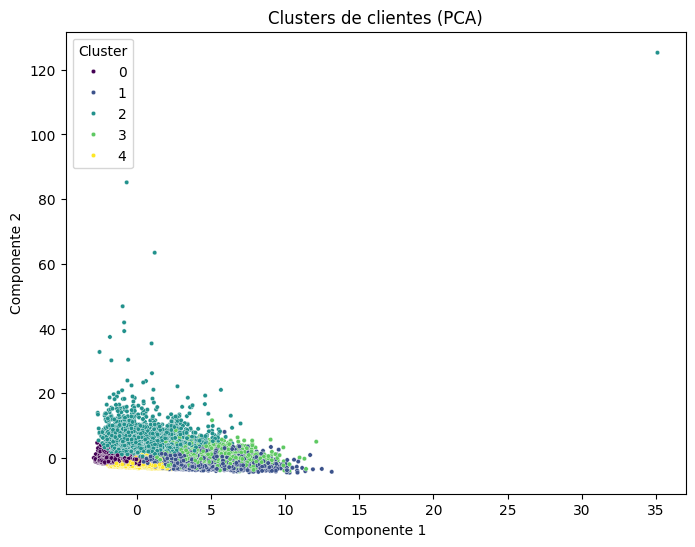

In [11]:
# Visualización PCA con clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='viridis', s=10)
plt.title('Clusters de clientes (PCA)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Cluster')
plt.show()


In [12]:
# Análisis de tasa de morosidad por cluster
if 'TARGET' in application.columns:
    cluster_risk = application.groupby('Cluster')['TARGET'].mean()
    print('Tasa de morosidad por cluster:')
    print(cluster_risk)


Tasa de morosidad por cluster:
Cluster
0    0.098915
1    0.082382
2    0.064922
3    0.061898
4    0.054325
Name: TARGET, dtype: float64
